In [36]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

## Single 2D Agent

Hitting a static target

In [71]:
# METAVARS

# size of the signal array (consistant between signals)
n = 10

l_val = 0.4

m_val = 1

a_val=0.5

ref_bounds=None

# ------------------------- #

# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?) (REMOVED)

# motor transform matrix ("personality", whats my tendancy?)
motor_transform1 = np.eye(n)

# motor prior (privous motor signal)
motor_prior1 =   np.zeros((1,n))

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.eye(n)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.zeros((1,n))

# Initial behavior
behav1 = np.ones((1,n))
behav2 = np.ones((1,n))

# behav1 = np.random.rand(n)
# behav2 = (np.random.rand(n) - 0.5) * 20.0

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T_scaler = 0.1
T1 = np.eye(n) * T_scaler 

# -------------------------- #

# MAIN FEEDBACK CHAIN

# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# create a motor plan
def effect(motor_state, error, motor_transform):
    # print((motor_state, error, motor_transform))
    # if np.mean(np.abs(error)) <= 0.75:
    #     return motor_state
    lambda_val = l_val
    mu_val = m_val
    m_e = error @  motor_transform
    g_of_e_m = np.linalg.norm(error) * (m_e / np.linalg.norm(m_e))
    next_motor_state = mu_val * motor_state + lambda_val * g_of_e_m
    # print(lambda_val * g_of_e_m)
    return next_motor_state

# execute move
def move(motor_signal):
    i = np.identity(motor_signal.shape[0])
    return i * motor_signal

# -------------------------- #

# adjusts reference given error
def reference_update_true(reference, error):
    reference = reference - (error * a_val)
    if ref_bounds is not None:
        reference[reference > ref_bounds[1]] = ref_bounds[1]
        reference[reference < ref_bounds[0]] = ref_bounds[0]
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    return new_state

# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_sense, previous_move):
    # actual estimate
    state = (system_estimate * previous_sense) + (previous_move)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_move, previous_sense, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate




# agent two acts as the plant (error = control output)
def plant_control(control_signal, transition_matrix, state):
    output = control_signal @ transition_matrix + state
    return output




agent1 = Control_node(sensor=sense, 
                      comparator=compare, 
                      effector=effect,
                      motor=move,
                      system_estimate=A1,
                      internal_model=imc, 
                      internal_model_update=imc_update, 
                      reference_update=reference_update_true,
                      reference=R1,
                      motor_prior=motor_prior1,
                      motor_transform=motor_transform1,
                      init_behavior=behav1)

plant1 = Plant(transition_matrix=T1,
               transition_function=plant_control,
               state=behav2)


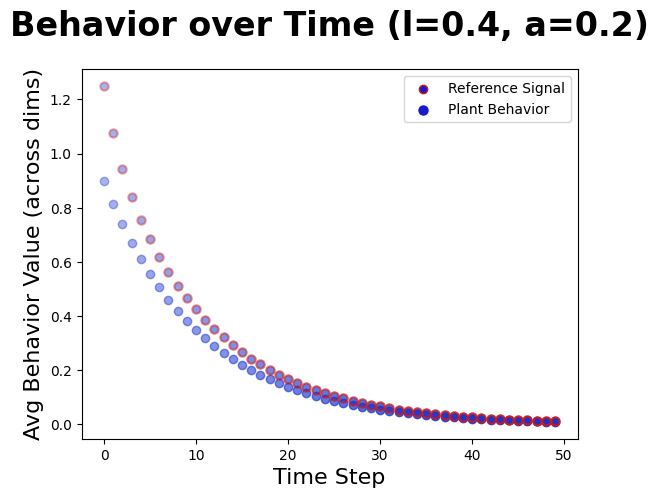

In [72]:
%matplotlib inline
plt.clf()
trials = 50
ticks = [n for n in range(trials)]
color = (0.1,0.2,0.8,0.1)
behavior1 = np.array([0,0])
agent1_error = []
agent1_state = []
agent1_behaviors = []
agent1_outside_behaviors = []
plant_outputs = []

state = np.array([2.5])
agent1_total_error = []

title_text = "Behavior over Time (l=0.4, a=0.2)"
#hfont = {'fontname':'SuperClarendon'}
#plt.scatter(R1[0],R1[1], c=(0.1,0.1,0.8), edgecolors=[0.8,0.1,0.1], linewidths=1.5)
for t in range(trials):
    color1 = [0.1,0.2,0.8, (t+30)/(trials+30)]
    b1 = agent1.go(state)   
    plant_output = plant1.transition(b1)

    # Loggers
    agent1_error.append(agent1.get_error())
    agent1_state.append(agent1.get_state())
    agent1_behaviors.append(agent1.get_output())
    agent1_outside_behaviors.append(b1)
    
    
    plant_outputs.append(plant_output)
    agent1_total_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))

    behavior1 = b1
    state = plant_output
    
    color = [0.1,0.1,0.8, (t+30)/(trials+30)]
    plt.scatter(t,np.mean(plant_output[0]),c=tuple(color1))
    pl.scatter(t,np.mean(agent1.get_reference()[0]),c=tuple(color1), edgecolors=[0.8,0.1,0.1, color1[3]], linewidth=1.5)
    plt.legend([[np.mean(agent1.get_reference()[0]), 0], state], labels=["Reference Signal", "Plant Behavior"])
    lg = plt.gca().get_legend()
    lg.legend_handles[0].set_color((0.1,0.1,0.8))
    lg.legend_handles[0].set_edgecolor((0.8,0.1,0.1))
    lg.legend_handles[1].set_color((0.1,0.1,0.8))
    display.clear_output(wait=True)
    plt.title(title_text, weight='bold', fontsize=24, pad=24)
    plt.ylabel("Avg Behavior Value (across dims)", fontsize=16)
    plt.xlabel("Time Step", fontsize=16)
    display.display(plt.gcf())

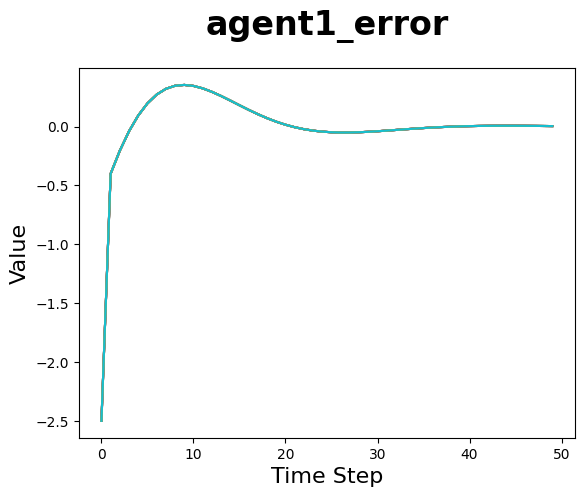

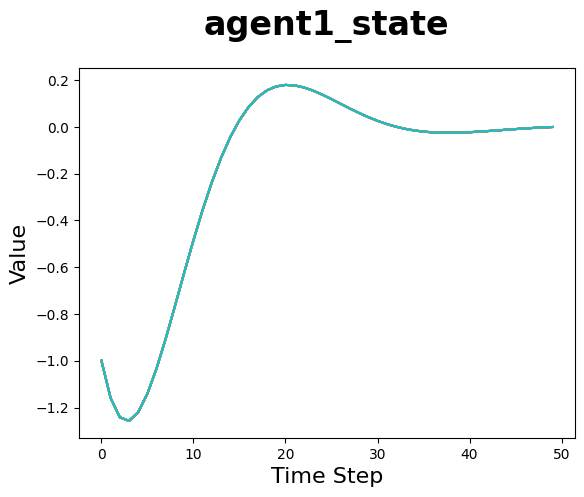

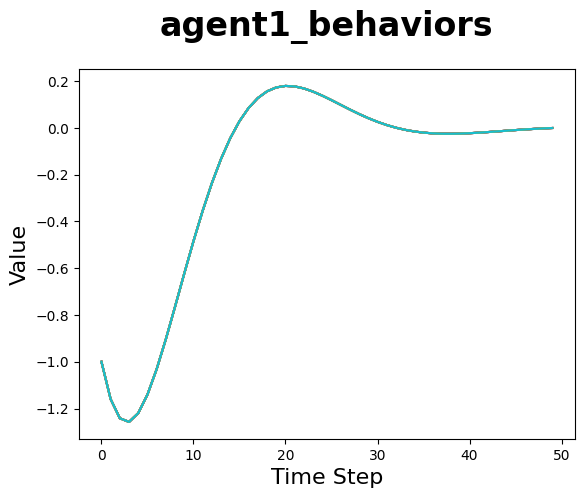

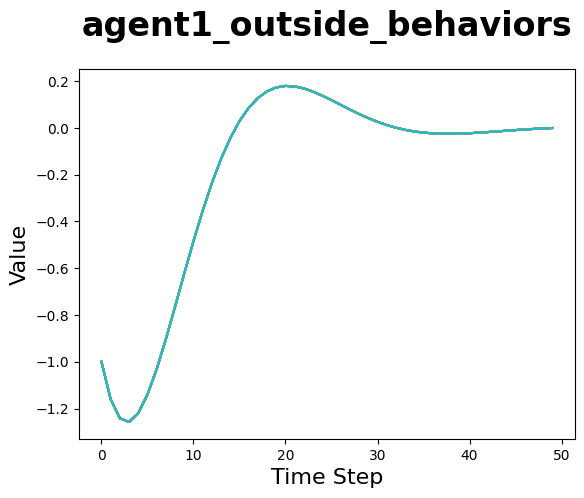

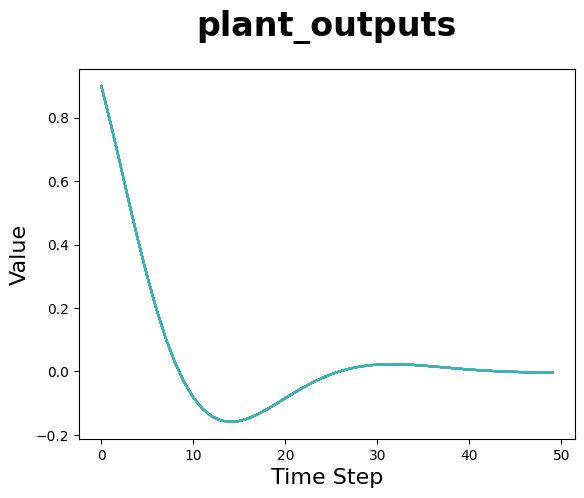

In [64]:
def plot_array(arr, arr_name):
    plt.clf()
    plt.plot(np.squeeze(arr))
    plt.title(f"{arr_name}", weight='bold', fontsize=24, pad=24)
    plt.xlabel("Time Step", fontsize=16)
    plt.ylabel("Value", fontsize=16)
    display.display(plt.gcf())

g = [agent1_error,
    agent1_state,
    agent1_behaviors,
    agent1_outside_behaviors,
    plant_outputs]
gn = ["agent1_error",
      "agent1_state",
      "agent1_behaviors",
      "agent1_outside_behaviors",
      "plant_outputs"]

for a,n in zip(g,gn):
    plot_array(a,n)
# plot_array(agent1_behaviors, "agent1_behaviors")
# plot_array(agent1_error, "agent1_error")

## Double Agent

Two agent interaction

In [77]:
# METAVARS

# size of the signal array (consistant between signals)
n = 10

l_val = 0.4

m_val = 1 # DO NOT CHANGE

a_val = 0.5

# output_limits=(-10.0,10.0)
output_limits=(None,None)
    
# ref_bounds = (0,5)
ref_bounds = None


# ------------------------- #

# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?) (REMOVED)

# motor transform matrix ("personality", whats my tendancy?)
motor_transform1 = np.eye(n)
motor_transform2 = np.eye(n)

# motor prior (privous motor signal)
motor_prior1 = np.ones((1,n))
motor_prior2 = np.ones((1,n))
# motor_prior1 =   np.zeros((1,n))
# motor_prior2 =   np.zeros((1,n))

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.eye(n)
A2 = np.eye(n)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.full((1,n), 1)
R2 = np.full((1,n), 2)
# R1 = np.zeros((1,n))
# R2 = np.zeros((1,n))
# R1 = np.random.rand(n).reshape((1,n))
# R2 = np.random.rand(n).reshape((1,n))

# Initial behavior
# behav1 = np.zeros((1,n))
# behav2 = np.zeros((1,n))
# behav1 = np.ones((1,n))
# behav2 = np.ones((1,n))
behav1 = np.full((1,n), 2)
behav2 = np.full((1,n), 1)

# behav1 = np.random.rand(n)
# behav2 = (np.random.rand(n) - 0.5) * 20.0

# # transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
# T_scaler = 0.1
# T1 = np.eye(n) * T_scaler 

# -------------------------- #

# MAIN FEEDBACK CHAIN

# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# create a motor plan
def effect(motor_state, error, motor_transform):
    # print((motor_state, error, motor_transform))
    # if np.mean(np.abs(error)) <= 0.75:
    #     return motor_state
    lambda_val = l_val
    mu_val = m_val
    m_e = error @  motor_transform
    g_of_e_m = np.linalg.norm(error) * (m_e / np.linalg.norm(m_e))
    next_motor_state = mu_val * motor_state + lambda_val * g_of_e_m
    # print(lambda_val * g_of_e_m)
    return next_motor_state

# execute move
def move(motor_signal):
    i = np.identity(motor_signal.shape[0])
    return i * motor_signal

# -------------------------- #

# adjusts reference given error
def reference_update_true(reference, error):
    reference = reference - (error * a_val)
    if ref_bounds is not None:
        reference[reference > ref_bounds[1]] = ref_bounds[1]
        reference[reference < ref_bounds[0]] = ref_bounds[0]
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

# def reference_update_sigmoid(reference, error):
#     # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
#     sqr_error = np.square(error)
#     reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
#     # k = 0.1
#     # k =  zero_sigmoid(error)
#     # reference = reference - (error * k)
#     return reference

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    return new_state

# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_sense, previous_move):
    # actual estimate
    state = (system_estimate * previous_sense) + (previous_move)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_move, previous_sense, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate




# agent two acts as the plant (error = control output)
def plant_control(control_signal, transition_matrix, state):
    output = control_signal @ transition_matrix + state
    return output

agent1 = Control_node(sensor=sense, 
                      comparator=compare, 
                      effector=effect,
                      motor=move,
                      system_estimate=A1,
                      internal_model=imc, 
                      internal_model_update=imc_update, 
                      reference_update=reference_update_true,
                      reference=R1,
                      motor_prior=motor_prior1,
                      motor_transform=motor_transform1,
                      init_behavior=behav1,
                      output_limits=output_limits)

agent2 = Control_node(sensor=sense, 
                      comparator=compare, 
                      effector=effect,
                      motor=move,
                      system_estimate=A2,
                      internal_model=imc, 
                      internal_model_update=imc_update, 
                      reference_update=reference_update_true,
                      reference=R2,
                      motor_prior=motor_prior2,
                      motor_transform=motor_transform2,
                      init_behavior=behav2,
                      output_limits=output_limits)

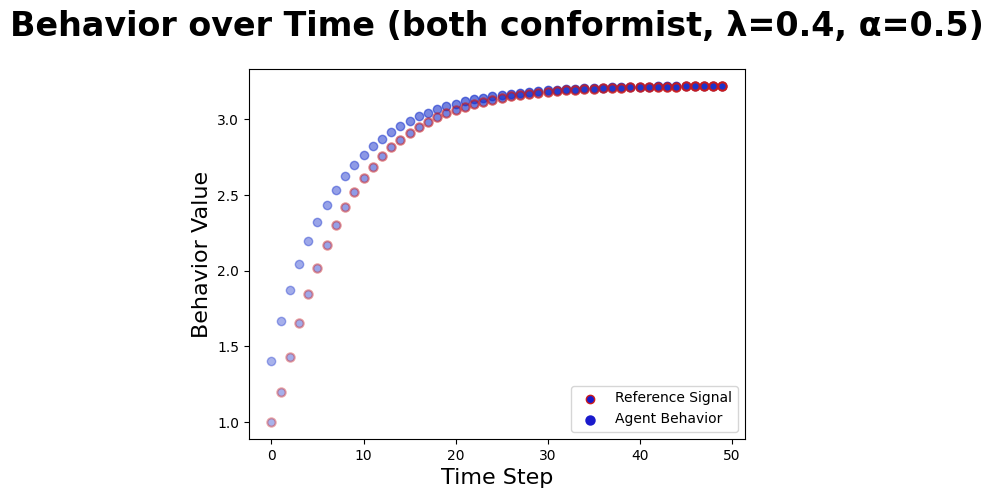

In [78]:
%matplotlib inline
plt.clf()
trials = 50
ticks = [n for n in range(trials)]
color = (0.1,0.2,0.8,0.1)
behavior1 = np.array([0,0])

#agent1_loggers
agent1_error = []
agent1_state = []
agent1_behaviors = []
agent1_outside_behaviors = []
agent1_references = []

#agent2_loggers
agent2_behaviors = []
agent2_references = []

state = np.full((1,n), 1.00001)
print(state)
agent1_total_error = []

title_text = "Behavior over Time (both conformist, λ=0.4, α=0.5)"

#hfont = {'fontname':'SuperClarendon'}
#plt.scatter(R1[0],R1[1], c=(0.1,0.1,0.8), edgecolors=[0.8,0.1,0.1], linewidths=1.5)
for t in range(trials):
    color1 = [0.1,0.2,0.8, (t+30)/(trials+30)]
    b1 = agent1.go(state)   
    b2 = agent2.go(b1)

    # Loggers
    agent1_references.append(agent1.get_reference())
    agent1_error.append(agent1.get_error())
    agent1_state.append(agent1.get_state())
    agent1_behaviors.append(agent1.get_output())
    
    agent1_outside_behaviors.append(b1)
    
    agent2_behaviors.append(b2)
    agent2_references.append(agent2.get_reference())
    
    agent1_total_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))

    behavior1 = b1
    state = b2
    
    color = [0.1,0.1,0.8, (t+30)/(trials+30)]
    plt.scatter(t,np.mean(b2[0]),c=tuple(color1))
    pl.scatter(t,np.mean(agent1.get_reference()[0]),c=tuple(color1), edgecolors=[0.8,0.1,0.1, color1[3]], linewidth=1.5)
    plt.legend([[np.mean(agent1.get_reference()[0]), 0], state], labels=["Reference Signal", "Agent Behavior"])
    lg = plt.gca().get_legend()
    lg.legend_handles[0].set_color((0.1,0.1,0.8))
    lg.legend_handles[0].set_edgecolor((0.8,0.1,0.1))
    lg.legend_handles[1].set_color((0.1,0.1,0.8))
    display.clear_output(wait=True)
    plt.title(title_text, weight='bold', fontsize=24, pad=24)
    plt.ylabel("Behavior Value", fontsize=16)
    plt.xlabel("Time Step", fontsize=16)
    display.display(plt.gcf())

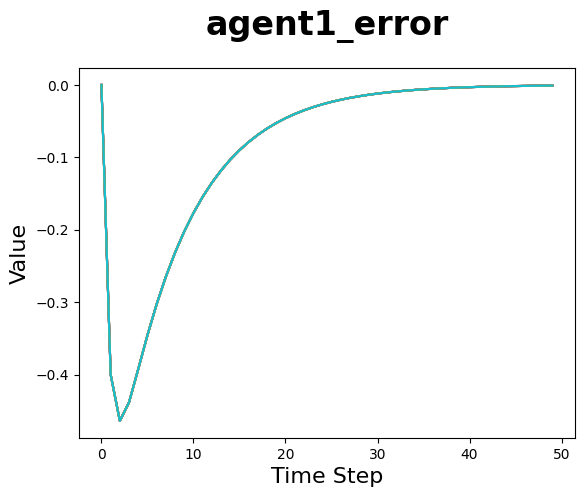

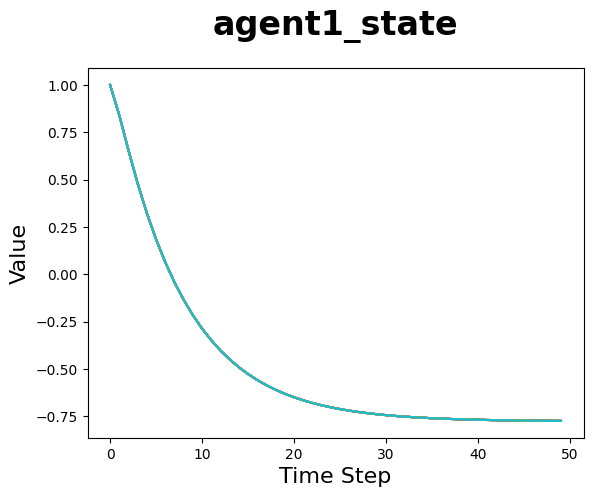

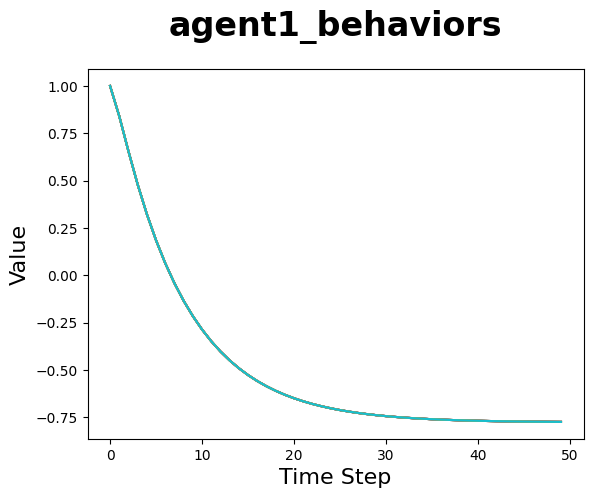

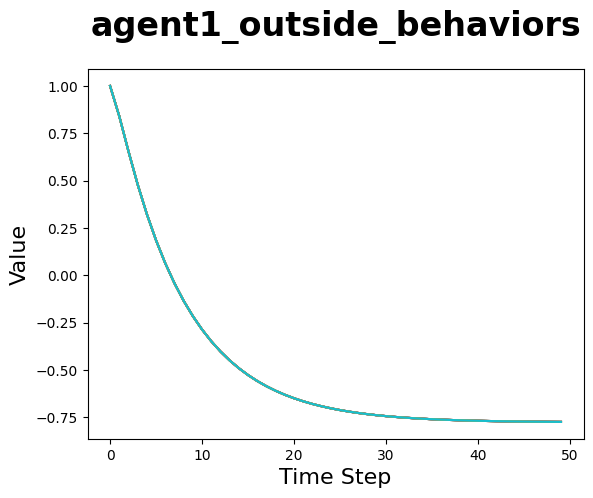

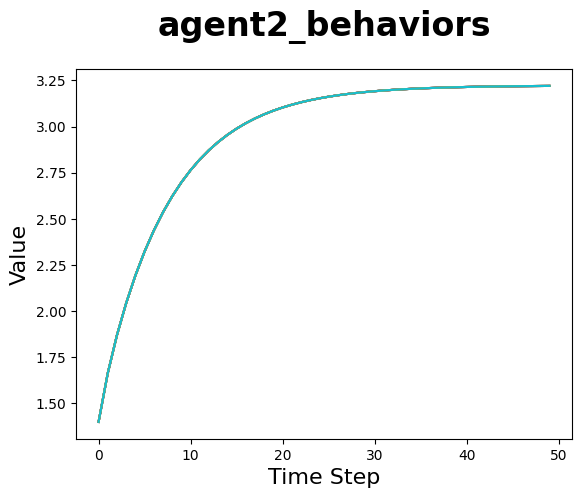

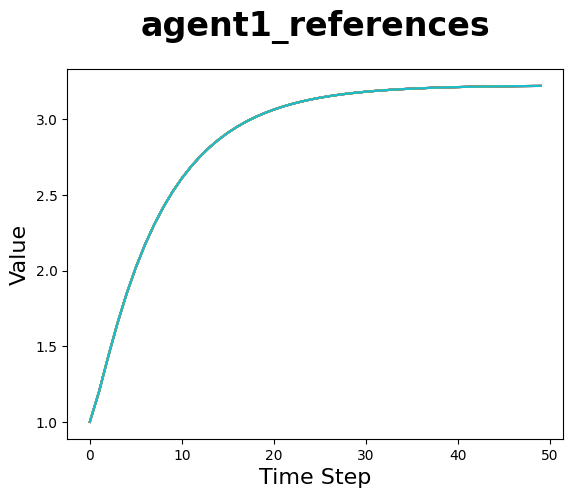

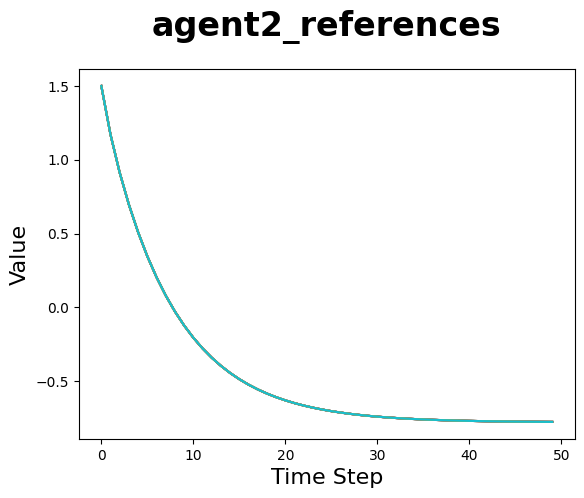

In [79]:
def plot_array(arr, arr_name):
    plt.clf()
    plt.plot(np.squeeze(arr))
    plt.title(f"{arr_name}", weight='bold', fontsize=24, pad=24)
    plt.xlabel("Time Step", fontsize=16)
    plt.ylabel("Value", fontsize=16)
    display.display(plt.gcf())

g = [agent1_error,
    agent1_state,
    agent1_behaviors,
    agent1_outside_behaviors,
    agent2_behaviors,
    agent1_references,
    agent2_references]
gn = ["agent1_error",
      "agent1_state",
      "agent1_behaviors",
      "agent1_outside_behaviors",
      "agent2_behaviors",
      "agent1_references",
      "agent2_references"]

for a,n in zip(g,gn):
    plot_array(a,n)
# plot_array(agent1_behaviors, "agent1_behaviors")
# plot_array(agent1_error, "agent1_error")

# OLD

## The three strategies

conformist x conformist in blue

stubborn x conformist in green

mixed/sigmoid x conformist in red

In [381]:
# seed = random.randrange(1000)
seed = 22
np.random.seed(seed)
print("Seed was:", seed)

behav_size = 1
sigmoid_k = 200000000000
sigmoid_b = 40
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(1, behav_size)
B2 = np.random.rand(1, behav_size)

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.2])
T2 = np.array([0.2])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.2
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 22


Seed was: 21

 Sigmoid Model Agents (Error Relative to Expectation)


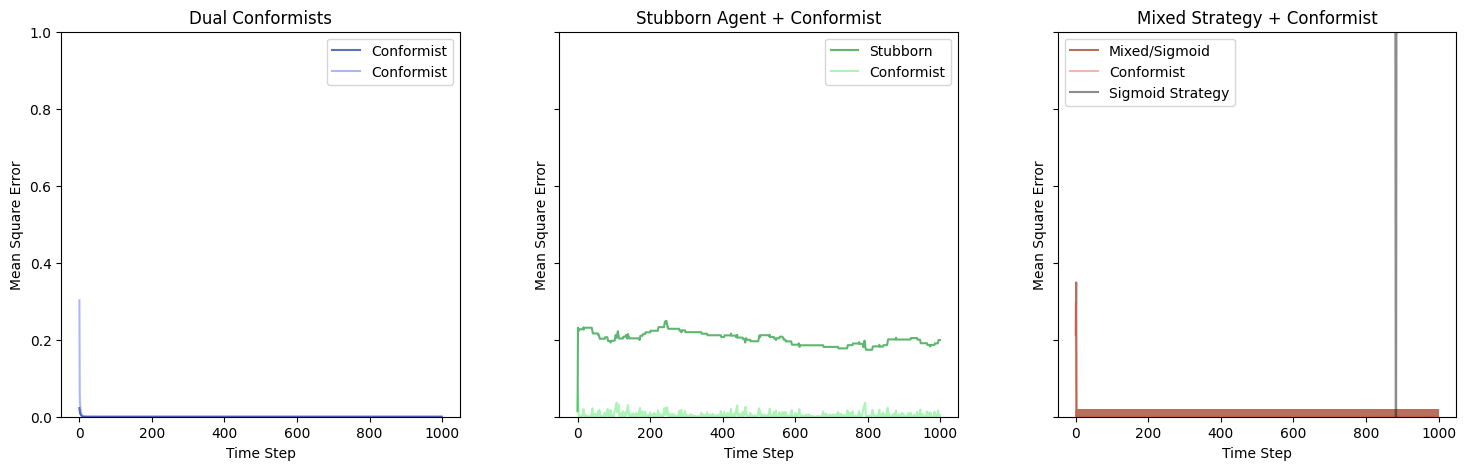

In [385]:
# seed = random.randrange(1000)
seed = 21
np.random.seed(seed)
print("Seed was:", seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    sigmoid_value = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        # agent1_control.append(agent1.get_output())
        # agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        # agent1_behaviors.append(b1)
        # agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    if agents_label[param%3] == "Conformist":
      ax[ai].set_title('Dual Conformists')
    elif agents_label[param%3] == "Stubborn":
      ax[ai].set_title('Stubborn Agent + Conformist')
    else:
      ax[ai].set_title('Mixed Strategy + Conformist')
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

### Aggregate Simulations

Seed was: 37
Mean Conformist Expectation Error at final 10 timesteps:  2.8331687731089364e-32
Mean Conformist Expectation Error at final 10 timesteps: 2.915993540830586e-32
Mean Conformist Preference Error at final 10 timesteps:  0.17358174375367977
Mean Conformist Preference Error at final 10 timesteps: 0.16721324691925088
---
Mean Conformist Expectation Error at final 10 timesteps:  0.0007651181421937628
Mean Stubborn Expectation Error at final 10 timesteps: 0.18069428058842457
Mean Conformist Preference Error at final 10 timesteps:  0.15830416181982893
Mean Stubborn Preference Error at final 10 timesteps: 0.1804503969167913
---


/var/folders/m2/79c0250s6dv437ybqm3rcw1r0000gp/T/ipykernel_46250/2883308246.py:130: RuntimeWarning: divide by zero encountered in divide
  ratio2.append(abs(d_behav2/agent1_raw_error_shifted))
/var/folders/m2/79c0250s6dv437ybqm3rcw1r0000gp/T/ipykernel_46250/2883308246.py:130: RuntimeWarning: invalid value encountered in divide
  ratio2.append(abs(d_behav2/agent1_raw_error_shifted))


Mean Conformist Expectation Error at final 10 timesteps:  0.00038495476649781635
Mean Mixed/Sigmoid Expectation Error at final 10 timesteps: 0.08682119103775979
Mean Conformist Preference Error at final 10 timesteps:  0.18013639435404577
Mean Mixed/Sigmoid Preference Error at final 10 timesteps: 0.17366975679578536
---

 Sigmoid Model Agents (Error Relative to Expectation)


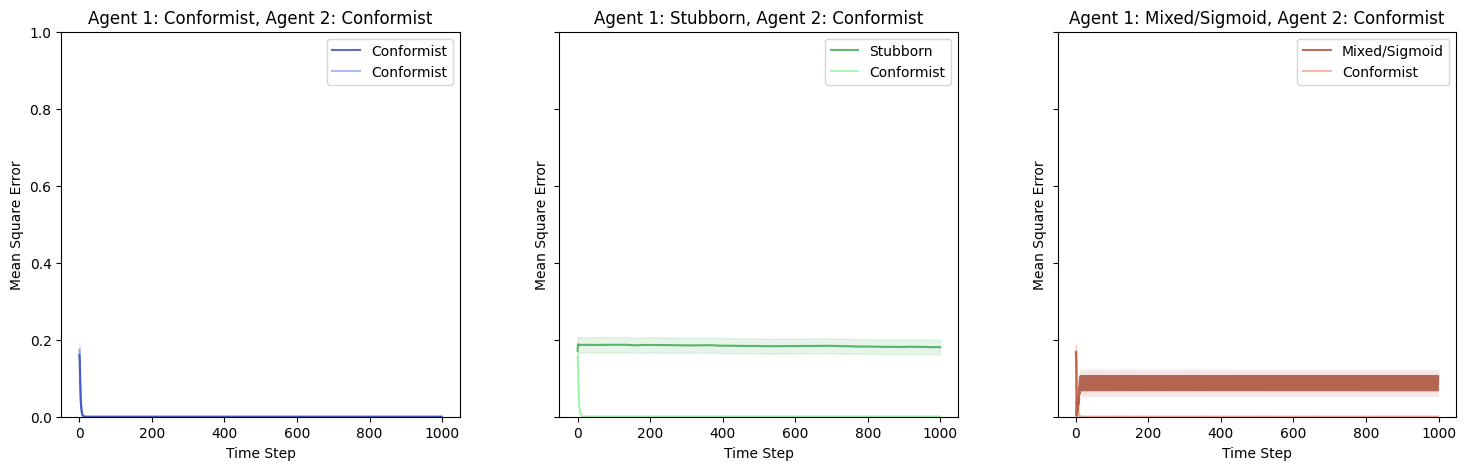

In [386]:
# seed = random.randrange(1000)
seed = 37
np.random.seed(seed)
print("Seed was:", seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 400
trials = 1000
time = [i for i in range(trials)]


color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]


# the type of experiment
for ix, param in enumerate(param_vals):
    agent1_pref_errors = []
    agent2_pref_errors = []
    agent1_errors = []
    agent2_errors = []
    agent1_raw_errors = []
    agent2_raw_errors = []
    agent1_behaviorss = []
    agent2_behaviorss = []
    ratio1 = []
    ratio2 = []
    # the experiments
    for e in range(experiments):
      behav_1 = np.random.rand(1,behav_size)
      behav_2 = np.random.rand(1,behav_size)
      R1 = np.random.rand(1,behav_size)
      R2 = np.random.rand(1,behav_size)
      b1 = np.random.rand(1,behav_size)
      b2 = np.random.rand(1,behav_size)
      conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
      system_estimate=A2, reference=R2, init_behavior=behav_2)

      conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
      plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))
      agents1 = [conformist2, stubborn, sigmoid]
      agents2 = [conformist1, conformist1, conformist1]

      # b1 = np.random.rand(1, 1)
      # b2 = np.random.rand(1, 1)

      agent1 = agents1[param]
      agent2 = agents2[0]
      agent1_error = []
      agent2_error = []
      agent1_pref_error = []
      agent2_pref_error = []
      agent1_raw_error = []
      agent2_raw_error = []
      sigmoid_value = []
      agent1_behaviors = []
      agent2_behaviors = []

      # the time steps
      for t in range(trials):
          color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
          color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]

          agent1_pref_error.append(np.sum(np.square(R1-b2))/behav_size)
          agent2_pref_error.append(np.sum(np.square(R2-b1))/behav_size)

          b1_control = agent1.go(b2)   
          b2_control = agent2.go(b1)

          agent1_behaviors.append(b1)
          agent2_behaviors.append(b2)

          agent1_raw_error.append(agent1.get_error()[0][0])
          agent2_raw_error.append(agent2.get_error()[0][0])


          b1 = plant1.transition(b1_control)
          b2 = plant2.transition(b2_control)

          agent1_error.append(np.sum(np.square(agent1.get_error())[0])/behav_size)
          agent2_error.append(np.sum(np.square(agent2.get_error())[0])/behav_size)

      agent1_errors.append(agent1_error)
      agent2_errors.append(agent2_error)
      agent1_pref_errors.append(agent1_pref_error)
      agent2_pref_errors.append(agent2_pref_error)
      agent1_raw_errors = []
      agent2_raw_errors = []
      agent1_behaviorss = []
      agent1_behaviorss = []

      dx = 1

      b1_flat = [i[0][0]for i in agent1_behaviors]
      b2_flat = [i[0][0]for i in agent2_behaviors]
      d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
      d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
      agent1_raw_error.insert(-1, 1)
      agent2_raw_error.insert(-1, 1)
      agent1_raw_error_shifted = agent1_raw_error[1:]
      agent2_raw_error_shifted = agent2_raw_error[1:]
      ratio1.append(abs(d_behav1/agent2_raw_error_shifted))
      ratio2.append(abs(d_behav2/agent1_raw_error_shifted))

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)
    pref_error1_mat = np.array(agent1_pref_errors)
    pref_error2_mat = np.array(agent2_pref_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    mean_pref_error1 = np.average(pref_error1_mat, axis=0)
    mean_pref_error2 = np.average(pref_error2_mat, axis=0)
    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    std_pref_error1  = pref_error1_mat.std(0)
    std_pref_error2  = pref_error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 2.96 * std_error1/np.sqrt(trials)
    ci2 = 2.96 * std_error2/np.sqrt(trials)
    pref_ci1 = 1.96 * std_pref_error1/np.sqrt(trials)
    pref_ci2 = 1.96 * std_pref_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)

    pref_upper1 = mean_pref_error1+pref_ci1
    pref_lower1 = mean_pref_error1-pref_ci1
    pref_upper1 = pref_upper1.reshape(trials,)
    pref_lower1 = pref_lower1.reshape(trials,)
    pref_upper2 = mean_pref_error2+pref_ci2
    pref_lower2 = mean_pref_error2-pref_ci2
    pref_upper2 = pref_upper2.reshape(trials,)
    pref_lower2 = pref_lower2.reshape(trials,)
    
    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, mean_error1, color=color,label=agents_label[param])
    ax[ai].plot(time, mean_error2, color=color_c, label="Conformist")
    ax[ai].fill_between(t, lower1, upper1, color=color, alpha=.1)
    ax[ai].fill_between(t, lower2, upper2, color=color_c, alpha=.1)
    # ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    # ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    ax[ai].set_title('Agent 1: {}, Agent 2: Conformist'.format(agents_label[param]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")
    # ax[ai].tick_params(axis='y')
    print("Mean Conformist Expectation Error at final 10 timesteps: ", np.mean(mean_error2[-10:]))
    print("Mean {} Expectation Error at final 10 timesteps: {}".format(agents_label[param], np.mean(mean_error1[-10:])))
    print("Mean Conformist Preference Error at final 10 timesteps: ", np.mean(mean_pref_error2[-1]))
    print("Mean {} Preference Error at final 10 timesteps: {}".format(agents_label[param], np.mean(mean_pref_error1[-1])))
    print("---")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

## Derivative Behavior / Error Correlation

We are hoping to see high correlation of behavior change in one agent vs error in the other, particularly in times of drastic change. High correlation suggests the agent can use these periods to better infer the error and this parameters of the counterpart based on their future actions.

In [165]:
def matrix_deriv(mat, features, steps):
  trans = mat.transpose()
  deriv = np.empty([features, steps-1])
  for feat in range(len(trans)):
    deriv[feat] = np.diff(trans[feat], 1)
  return deriv.transpose()

In [346]:
# seed = random.randrange(1000)
seed = 378
np.random.seed(seed)

behav_size = 50
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(behav_size, behav_size)
B2 = np.random.rand(behav_size, behav_size)
# B1 = np.array([[1]])
# B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
# T1 = np.array([.05])
# T2 = np.array([.05])
T1 = np.array([.1])
T2 = np.array([.1])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.3
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 88


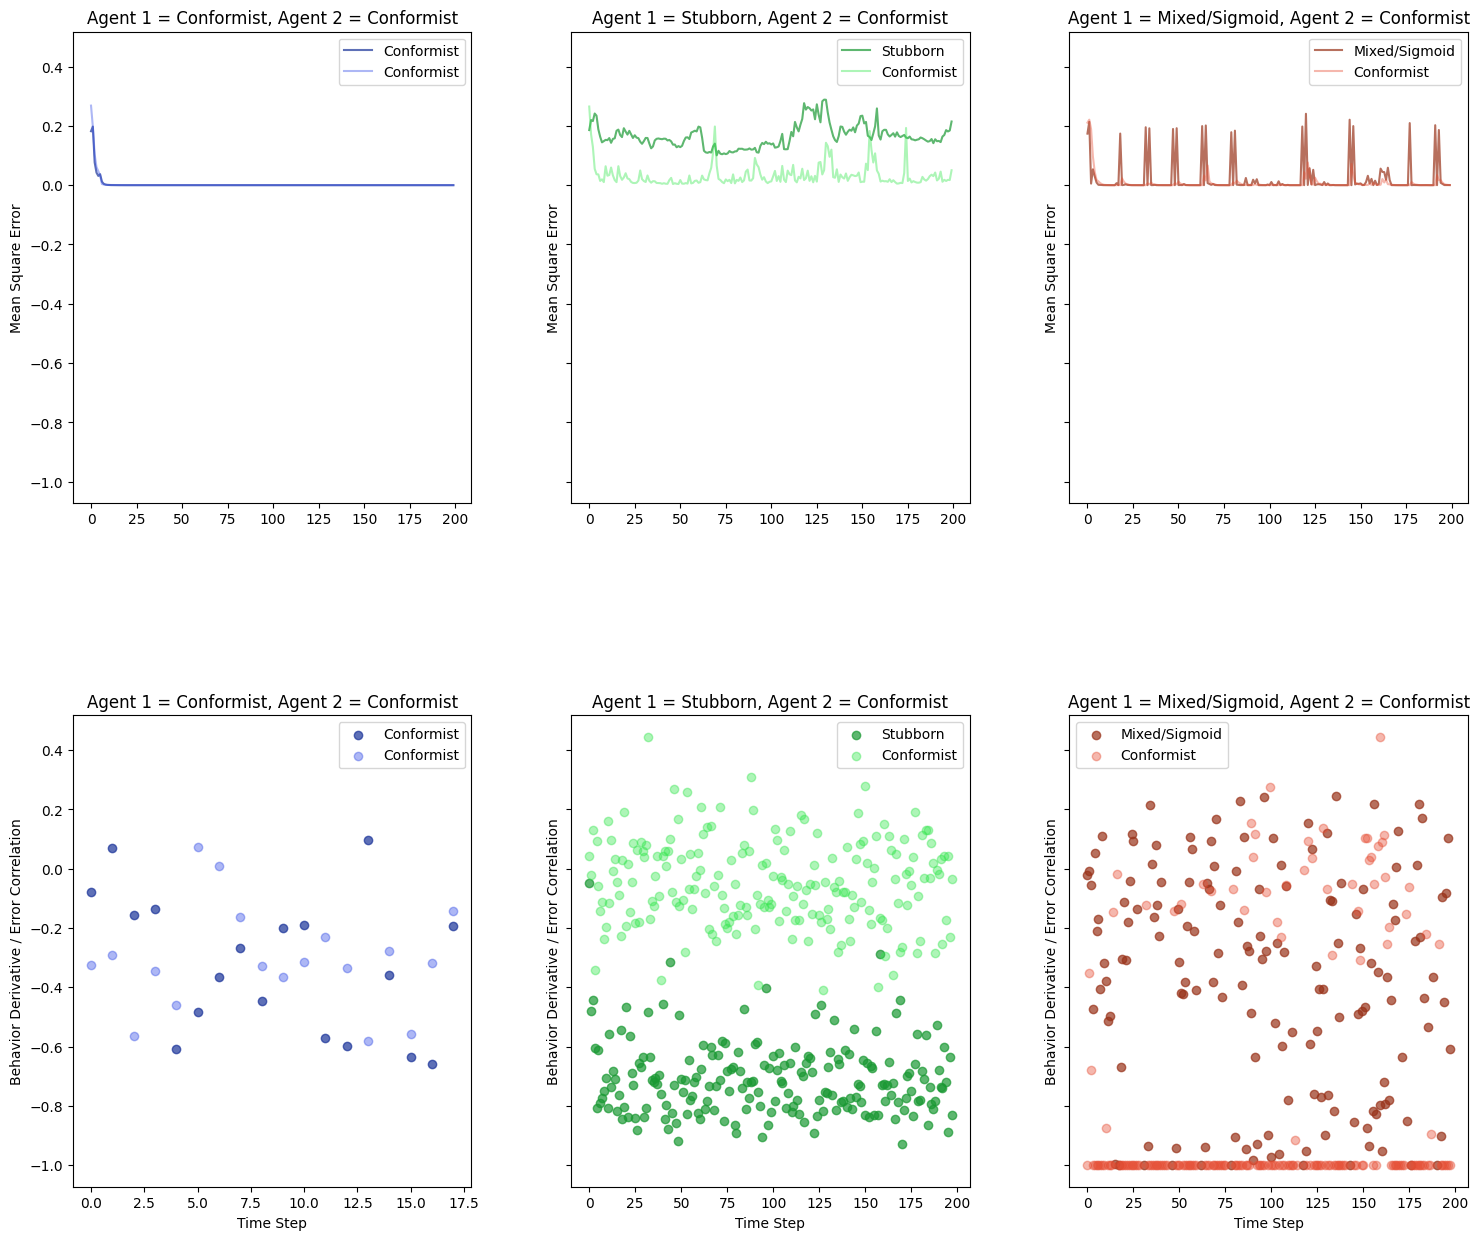

In [348]:
# seed = random.randrange(1000)
seed = 88
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 200
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0])
        agent2_raw_error.append(agent2.get_error()[0])
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0]for i in agent1_behaviors]
    # print("ag 1 behaviors: ", agent1_behaviors)
    # print("ag 1 flat behaviors: ", b1_flat)
    b2_flat = [i[0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    # d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav1 = matrix_deriv(np.array(b1_flat), behav_size, trials)[:-1]
    # print("ag 1 behav deriv: ", d_behav1)
    # d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    d_behav2 = matrix_deriv(np.array(b2_flat), behav_size, trials)[:-1]
    # print("agent1_raw_error: ", agent1_raw_error)
    # agent1_raw_error.insert(-1, 1)
    # print("agent1_raw_error inserted: ", agent1_raw_error)
    # agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[2:]
    agent2_raw_error_shifted = agent2_raw_error[2:]

    # print(agents_label[param%3], "ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    # print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    # print(agents_label[param%3], "+ Conformist covariance:", np.cov(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted)))
    # print(agents_label[0], "&",agents_label[param%3], "covariance:", np.cov(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted)))
    # print(agents_label[param%3], "& Conformist Pearson R:", np.corrcoef(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted))[0][1])
    # print(agents_label[0], "&", agents_label[param%3], " Pearson R:", np.corrcoef(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted))[0][1])
    # print("---")

    # print(agents_label[param])
    # print("error: ", agent2_raw_error_shifted)
    # print("d_behav: ", d_behav1)
    coef1 = [np.corrcoef(d_behav1[i], agent2_raw_error_shifted[i])[0][1] for i in range(len(d_behav1))]
    # print(coef1)
    coef2 = [np.corrcoef(d_behav2[i], agent1_raw_error_shifted[i])[0][1] for i in range(len(d_behav2))]
    
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef1, color=color, label="{}".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted), color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef2, color=color_c, label="Conformist")
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted), color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_ylim(0,1)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Derivative / Error Correlation")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")

plt.show()

### Show That Sigmoid Agent Can Mimic Conformist 

In [379]:
# seed = random.randrange(1000)
seed = 22
np.random.seed(seed)
print("Seed was:", seed)

behav_size = 1
sigmoid_k = 99999
sigmoid_b = -5
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(1, behav_size)
B2 = np.random.rand(1, behav_size)

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.2])
T2 = np.array([0.2])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.2
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 22


Seed was: 159

 Sigmoid Model Agents (Error Relative to Expectation)


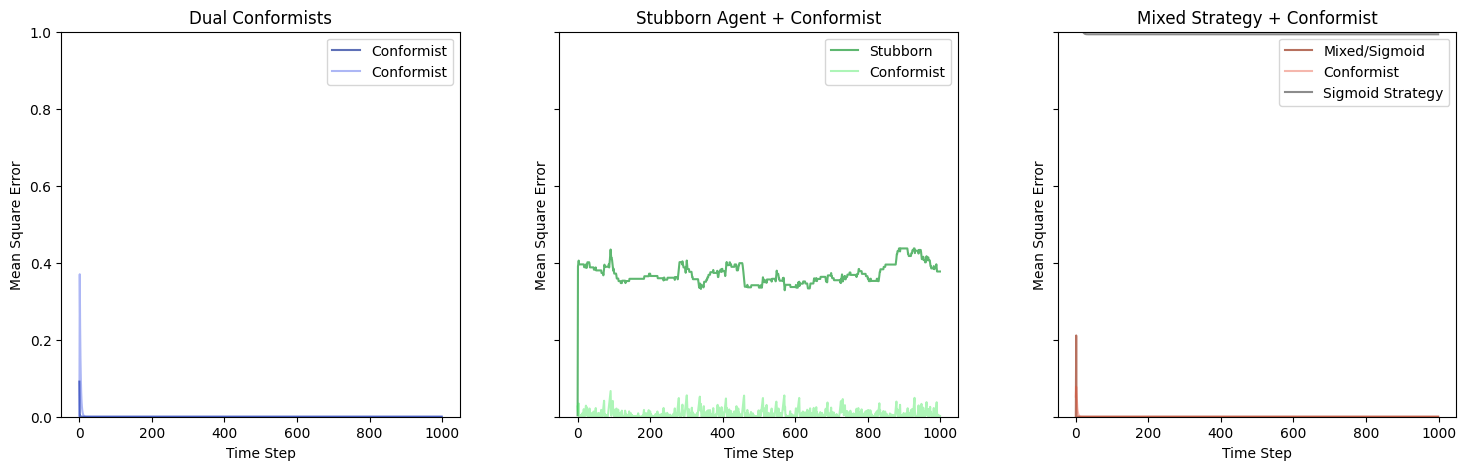

In [380]:
seed = random.randrange(1000)
# seed = 14
np.random.seed(seed)
print("Seed was:", seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    sigmoid_value = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        # agent1_control.append(agent1.get_output())
        # agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        # agent1_behaviors.append(b1)
        # agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    if agents_label[param%3] == "Conformist":
      ax[ai].set_title('Dual Conformists')
    elif agents_label[param%3] == "Stubborn":
      ax[ai].set_title('Stubborn Agent + Conformist')
    else:
      ax[ai].set_title('Mixed Strategy + Conformist')
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

### Scratch Work

In [183]:
# investigating -1 conformist correlations in sigmoid case
print(coef2[54])
print(agent1_raw_error_shifted[54])
print(d_behav2[54])




-1.0
[ 0.01454089 -0.03218108 -0.02313377 -0.00850707 -0.01922031 -0.01679566
  0.01273211 -0.00429548  0.01957796 -0.03047746 -0.02216484 -0.03975788
  0.00681055 -0.01449988 -0.01151191 -0.00864103 -0.02958216  0.00180413
 -0.00221501 -0.02970185  0.00749252  0.01372076  0.01500398 -0.00993083
 -0.02931745 -0.02013294 -0.01334102 -0.01371742 -0.0117961  -0.00565544
  0.00504841 -0.01573635 -0.01987115 -0.0191835  -0.03256478 -0.00899477
 -0.01350633 -0.01004508 -0.02473687  0.00992636 -0.01566465 -0.0193648
 -0.0243776   0.00662096 -0.02030571 -0.02337517 -0.01222031 -0.02276325
 -0.01309425  0.03063215]
[-0.01454089  0.03218108  0.02313377  0.00850707  0.01922031  0.01679566
 -0.01273211  0.00429548 -0.01957796  0.03047746  0.02216484  0.03975788
 -0.00681055  0.01449988  0.01151191  0.00864103  0.02958216 -0.00180413
  0.00221501  0.02970185 -0.00749252 -0.01372076 -0.01500398  0.00993083
  0.02931745  0.02013294  0.01334102  0.01371742  0.0117961   0.00565544
 -0.00504841  0.01573

In [197]:
# investigating -1 conformist correlations in sigmoid case
print(coef1[84:87])
print(agent2_raw_error_shifted[85])
print(d_behav1[85])

[-0.9991014435608242, nan, -0.959678749500367]
[-0.03770918 -0.05964366 -0.05894456 -0.00916881 -0.00847428  0.0004833
 -0.01713752 -0.01971938 -0.11384336 -0.0017065  -0.09880912 -0.03233566
 -0.06434915 -0.06303439 -0.00203614 -0.00427229 -0.01819278 -0.00958058
 -0.0147159   0.00325058 -0.02329864 -0.03354375 -0.03235218 -0.07154833
 -0.08456604 -0.07224736 -0.00815107 -0.0904591  -0.08294256 -0.02042623
 -0.04912403 -0.05699172 -0.02419513 -0.0166227  -0.08161547 -0.06186383
 -0.04022385 -0.05988196 -0.10868714 -0.01317207 -0.09369284 -0.00925103
 -0.06266531 -0.06732191 -0.06723726 -0.02016818 -0.09947293 -0.00696132
 -0.10028535 -0.09641529]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
